# New tcoff

## Imports

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
from os.path import join as jn
from scipy.constants import k as kb, N_A as NA
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')

## Import shifts

In [2]:
SHIFTS = '/home/aria/landslide/RESULTS/IGPS_TDEP'

ts30 = np.load(jn(SHIFTS, 'ts30_all.npy'))

## Import Energies

In [3]:
ENERGIES = '/home/aria/landslide/RESULTS/IGPS_TDEP/MDOUT/'
en30 = np.genfromtxt(jn(ENERGIES,'30', 'summary.ETOT'))
en50 = np.genfromtxt(jn(ENERGIES,'50', 'summary.ETOT'))
#en30 = pd.DataFrame({'TIME': en30[:,0], 'ENERGY': en30[:,1]})       
#en50 = pd.DataFrame({'TIME': en50[:,0], 'ENERGY': en50[:,1]})

## Infering shifts at 50C and computing Tcoff

In [4]:
#Striding
en30_stride = en30[::50,0]
en50_stride = en50[::100,0]
#Some data is missing (end of 50C energies) so we cut in 30C energies and shifts
end = en50_stride.shape[0]
ts30_head = ts30[:,:end]
ts30_mean = np.mean(ts30_head, axis=-1)
en30_stride = en30_stride[:end]
#Computing exponentional factor
dE = en50_stride - en30_stride
#converting kcal/mol in J
dE=dE*4.184*10**3/(NA)
beta = lambda temp: 1/(kb*(temp+273.15))
exp_fact = np.exp(-(beta(50)-beta(30))*dE)

mult = np.multiply(exp_fact, ts30_head)

ts50_mean = np.divide(np.mean(np.multiply(exp_fact, ts30_head), axis=-1), np.mean(exp_fact))

#Computing tcoff
dT = 20
tcoff = (ts50_mean-ts30_mean)/(dT)*10**3

[-2.03574711e-01 -5.94392379e-01  9.44205294e-01 -2.55813430e-02
 -3.65186394e-01 -5.80826704e-01 -4.68479674e-01 -1.18940657e+00
 -1.39777716e-01 -9.54978229e-02 -4.19262949e-02 -7.12728087e-01
 -5.52513061e-02  9.92961904e-02 -1.09821592e-02 -1.95160036e-02
 -2.29674671e-01 -1.93412326e-01  1.13179450e-01  5.97269232e+00
 -7.66203542e+00 -6.95992206e+00 -1.73350786e-01  1.83780828e+00
  2.39865433e-01  9.89248171e+00  2.57129348e+00 -2.48610184e-02
 -3.25957542e-01 -4.89666251e-01 -7.47102022e-01 -7.46881724e-02
  7.79909096e-01 -1.48068769e-01  1.08937542e-01  1.03565326e-01
  4.17275627e-01 -3.21571731e-01 -1.91394092e-01  3.24862532e-01
  1.16157893e+00  1.10360130e+00 -2.98816852e-01 -4.07628707e-01
 -1.48504529e-01 -4.39198027e-01 -2.77432552e-01 -6.97975477e-02
 -1.42873217e+00  4.56466043e-02  5.37189249e-01  8.04800208e-01
  4.51024172e-01 -2.02536678e-01  1.80066722e-02  1.68312545e-01
  2.52742632e-01 -7.17675784e-02 -1.86589563e-01  3.81230815e-02
  1.17558881e+00 -4.71107

## Loading exp Tcoff

In [6]:
edh = np.genfromtxt(jn(SHIFTS, 'exp_nmr/dh.csv'), delimiter=',')
edh[edh== 0] = np.nan
indexes = np.where(~np.isnan(edh)==True)[0]
edh = edh[~np.isnan(edh)]
dh_exp = pd.DataFrame({'NUM': indexes, 'TCOFF': edh})

## Getting the structure back

In [7]:
_ = pkl.load(open(jn(SHIFTS, 'ts30.pdy'), 'rb')).drop(['SHIFT', 'STD_SHIFT'], axis=1)
dh_theo = _.loc[_['ATOMNAME']=='H'].reset_index().join(pd.DataFrame({'TCOFF': tcoff}))

## Comparing theory and exp

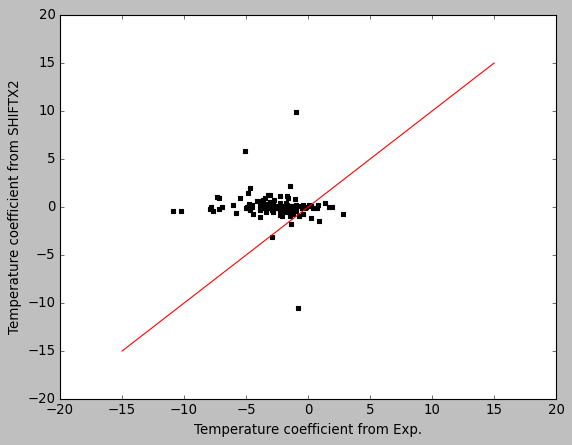

In [8]:
def getXY(exp_values, t_values):
    X, Y = [], []
    for elt in exp_values.itertuples():
        num = elt[1] 
        eshift = elt[-1]
        try:
            sshift = t_values.loc[t_values['NUM'] == num]['TCOFF'].values[0]
            X.append(eshift)
            Y.append(sshift)
        except IndexError:
            pass
    return X, Y

def expVt(exp_values, t_values):
    fig = plt.figure()
    X, Y = getXY(exp_values, t_values)
    plt.style
    plt.scatter(X, Y, marker='s', color='k')
    inf = min(plt.gca().get_ylim()[0],plt.gca().get_xlim()[0])
    sup = max(plt.gca().get_ylim()[1],plt.gca().get_xlim()[1])
    plt.plot([inf, sup], [inf, sup], color='r')
    plt.xlabel('Temperature coefficient from Exp.')
    plt.ylabel('Temperature coefficient from SHIFTX2')
#    plt.xlim(sup+1, inf-0.5)
#    plt.ylim(sup+1, inf-0.5)
    X = np.array(X).reshape(1, -1)
    Y = np.array(Y).reshape(1, -1)
    plt.show()
    plt.close(fig)

expVt(dh_exp, dh_theo)
